In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import os

In [2]:
# keras libraries
from tensorflow import keras
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model, Sequential
from keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix

Using TensorFlow backend.


In [3]:
import zipfile

zip_ref = zipfile.ZipFile('/content/drive/My Drive/Datasets/original(2).zip', 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

In [4]:
train_dir = "/tmp/cell_images/train/"
val_dir = "/tmp/cell_images/valid/"

Text(0.5, 1.0, 'Uninfected')

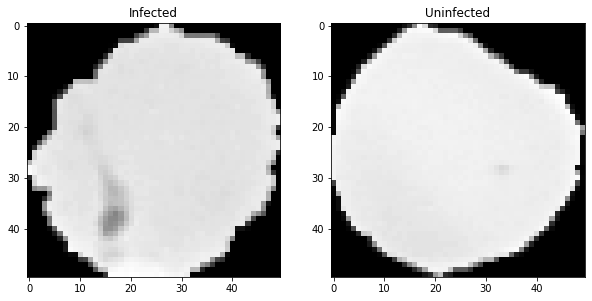

In [5]:
# infected pic
rand_norm = np.random.randint(0, len(os.listdir(train_dir+"Parasitized/")))
infected_pic = os.listdir(train_dir+"Parasitized/")[rand_norm]
infected_pic_address = train_dir+"Parasitized/"+infected_pic

# uninfected pic
rand_norm = np.random.randint(0, len(os.listdir(train_dir+"Uninfected/")))
uninfected_pic = os.listdir(train_dir+"Uninfected/")[rand_norm]
uninfected_pic_address = train_dir+"Uninfected/"+uninfected_pic

# load the images
infected_load = Image.open(infected_pic_address)
uninfected_load = Image.open(uninfected_pic_address)

# plot
f = plt.figure(figsize= (10,6))
a1 = f.add_subplot(1,2,1)
img_plot = plt.imshow(infected_load, cmap='gray')
a1.set_title('Infected')

a2 = f.add_subplot(1, 2, 2)
img_plot = plt.imshow(uninfected_load, cmap='gray')
a2.set_title('Uninfected')

In [6]:
width = 100
height = 100

In [7]:
# loading the images
train_datagen = ImageDataGenerator(rescale=1./255,
                            rotation_range=30,
                            zoom_range=0.15,
                            horizontal_flip=True,
                            fill_mode="nearest")

valid_datagen = ImageDataGenerator(rescale=1./255)


training_set = train_datagen.flow_from_directory(directory=train_dir,
                                           target_size=(width,height),
                                           shuffle=True,
                                           class_mode = 'categorical',
                                           batch_size = 32)

validation_set = valid_datagen.flow_from_directory(directory=val_dir,
                                           target_size=(width,height),
                                           class_mode = 'categorical',
                                           batch_size = 32)

Found 22046 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.


In [8]:
# ? ImageDataGenerator.flow_from_directory

In [9]:
### Create Model from scratch using CNN
model=Sequential()
model.add(Conv2D(filters=256,kernel_size=2,padding="same",activation="relu",input_shape=(width,height,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=128,kernel_size=2,padding="same",activation ="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())
model.add(Dense(2,activation="softmax"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 256)     3328      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 256)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 128)       131200    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 64)        32832     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)       

In [10]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [12]:
history = model.fit_generator(generator=training_set,
                             steps_per_epoch=len(training_set),
                              epochs=10,
                              validation_data=validation_set,
                              validation_steps=len(validation_set),
                              callbacks=[early_stop])

Epoch 1/10
689/689 [==============================] - 72s 105ms/step - loss: 0.6823 - accuracy: 0.5518 - val_loss: 0.3365 - val_accuracy: 0.7622
Epoch 2/10
689/689 [==============================] - 68s 99ms/step - loss: 0.2583 - accuracy: 0.9031 - val_loss: 0.1630 - val_accuracy: 0.9447
Epoch 3/10
689/689 [==============================] - 68s 99ms/step - loss: 0.1821 - accuracy: 0.9378 - val_loss: 0.1034 - val_accuracy: 0.9421
Epoch 4/10
689/689 [==============================] - 69s 99ms/step - loss: 0.1736 - accuracy: 0.9412 - val_loss: 0.1405 - val_accuracy: 0.9483
Epoch 5/10
689/689 [==============================] - 68s 99ms/step - loss: 0.1732 - accuracy: 0.9412 - val_loss: 0.0311 - val_accuracy: 0.9510
Epoch 6/10
689/689 [==============================] - 69s 100ms/step - loss: 0.1682 - accuracy: 0.9422 - val_loss: 0.0487 - val_accuracy: 0.9487
Epoch 7/10
689/689 [==============================] - 69s 100ms/step - loss: 0.1646 - accuracy: 0.9444 - val_loss: 0.0949 - val_accura

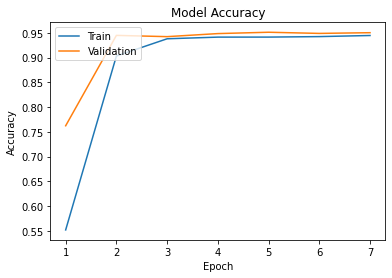

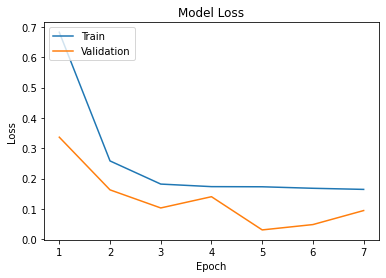

In [13]:
def plotLearningCurve(history,epochs=20):
    epochRange = range(1,epochs+1)
    plt.plot(epochRange,history.history['accuracy'])
    plt.plot(epochRange,history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train','Validation'],loc='upper left')
    plt.show()

    plt.plot(epochRange,history.history['loss'])
    plt.plot(epochRange,history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train','Validation'],loc='upper left')
    plt.show()

plotLearningCurve(history, epochs=len(history.history['accuracy']))

In [14]:
 model.save('malaria_model.h5')

In [15]:
# ? image.load_img

In [16]:
img=image.load_img('/tmp/cell_images/valid/Parasitized/ParasitizedC100P61ThinF_IMG_20150918_144104_cell_165.png',
                   target_size=(width,height))

In [17]:
x=image.img_to_array(img)
x

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

In [18]:
x.shape

(100, 100, 3)

In [19]:
x=x/255

In [20]:
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 100, 100, 3)

In [21]:
pred = np.argmax(model.predict(img_data), axis=1)
pred

array([0])

In [22]:
if(pred==1):
    print("Uninfected")
else:
    print("Infected")

Infected
